# Moving Beyond Linearity

In [61]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate
import statsmodels.api as sm

**1. In this exercise, you will further analyze the Wage data set**

*(a) Perform polynomial regression to predict wage using age. Use cross-validation to select the optimal degree d for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.*

In [7]:
wage_df = pd.read_csv(r'C:\Users\caine\OneDrive\Documents\statistical_learning_problems\0 datasets\Wage.csv')
wage_df.head()

,Unnamed: 0,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,155159,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,11443,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


To tackle this question we will first extract the response variable, wage, and the independent variable age. We will then transform the age vector into a matrix with each additional column representing the next polynomial of age. 

Using sklearn's `KFold` class and the `cross_validate` function we will perform cross validation and plot it on a chart. This will allow us to select the optimal degree for the polynomial. Once the optimal degree has been chosen we will fit a polynomial regression model with the selected degree and plot the fitted curve and the data.

The question also asks to compare this with the results of hypothesis testing using ANOVA. An ANOVA test is usually conducted to test if differences in the mean of different groups are statistically significant. In this context, the ANOVA can be used to test...

In [8]:
wage = wage_df['wage'].to_numpy()
age = wage_df['age'].to_numpy()

In [18]:
age

array([18, 24, 45, ..., 27, 27, 55], dtype=int64)

In [51]:
powers = np.arange(1, 10, 1).reshape(9, 1)
age_pows = age ** powers
age_pows

array([[              18,               24,               45, ...,
                      27,               27,               55],
       [             324,              576,             2025, ...,
                     729,              729,             3025],
       [            5832,            13824,            91125, ...,
                   19683,            19683,           166375],
       ...,
       [       612220032,       4586471424,     373669453125, ...,
             10460353203,      10460353203,    1522435234375],
       [     11019960576,     110075314176,   16815125390625, ...,
            282429536481,     282429536481,   83733937890625],
       [    198359290368,    2641807540224,  756680642578125, ...,
           7625597484987,    7625597484987, 4605366583984375]],
      dtype=int64)

In [38]:
age_pows[0:2, :]

array([[  18,   24,   45, ...,   27,   27,   55],
       [ 324,  576, 2025, ...,  729,  729, 3025]], dtype=int64)

In [33]:
wage.shape

(3000,)

In [24]:
k_fold = KFold(n_splits=5)

In [63]:
polynomials = []
cv_scores = []
for i in range(1, len(powers)+1):
    cv_results = cross_validate(estimator=LinearRegression(), X=age_pows.T[:, 0:i], y=wage, cv=k_fold, scoring='neg_mean_squared_error',)
    polynomials.append(i)
    cv_scores.append(cv_results['test_score'].mean() * -1)

cv_scores


[1675.0142380530044,
 1599.5982268539042,
 1594.7262162596164,
 1593.9141039099823,
 1595.4331311683372,
 1594.930289697439,
 1598.953359191816,
 1599.4419183478265,
 1599.4245417477928]

From the chart below we can see that the MSE is minimised at degree 4. However, there is little difference between 2 and 4 and so we opt for the simpler model.

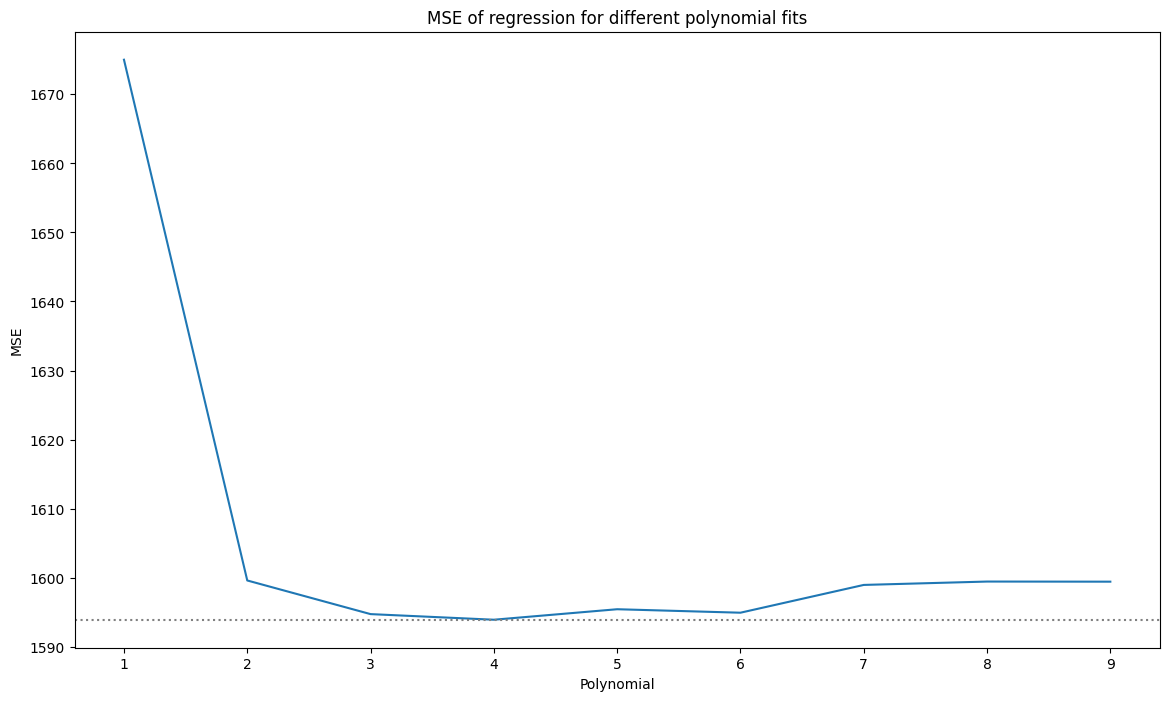

In [65]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
ax.plot(polynomials, cv_scores)
ax.set_title('MSE of regression for different polynomial fits')
ax.set_xlabel('Polynomial')
ax.set_ylabel('MSE')
ax.axhline(min(cv_scores), ls=':', c='grey')

In [68]:
polynomial_age_model = LinearRegression()
polynomial_age_model.fit(age_pows.T[:, 0:2], wage)

LinearRegression()

In [75]:
polynomial_age_model.coef_

array([ 5.29403003, -0.05300507])

In [78]:
age_range = np.arange(min(age), max(age), 1)
wage_preds = (age_range*polynomial_age_model.coef_[0]) + (age_range**2 *polynomial_age_model.coef_[1])

Below is the plot of the data and fitted polynomial regression model. A model with a polynomial of degree 2 seems to capture one aspect of how age influences wage. There is clearly a tendency for wages to rise as age increases and then after around 50 start to fall again. However, there seems to be a group of ultra high earners where age is not an influence on their wage.

Text(0, 0.5, 'Wage')

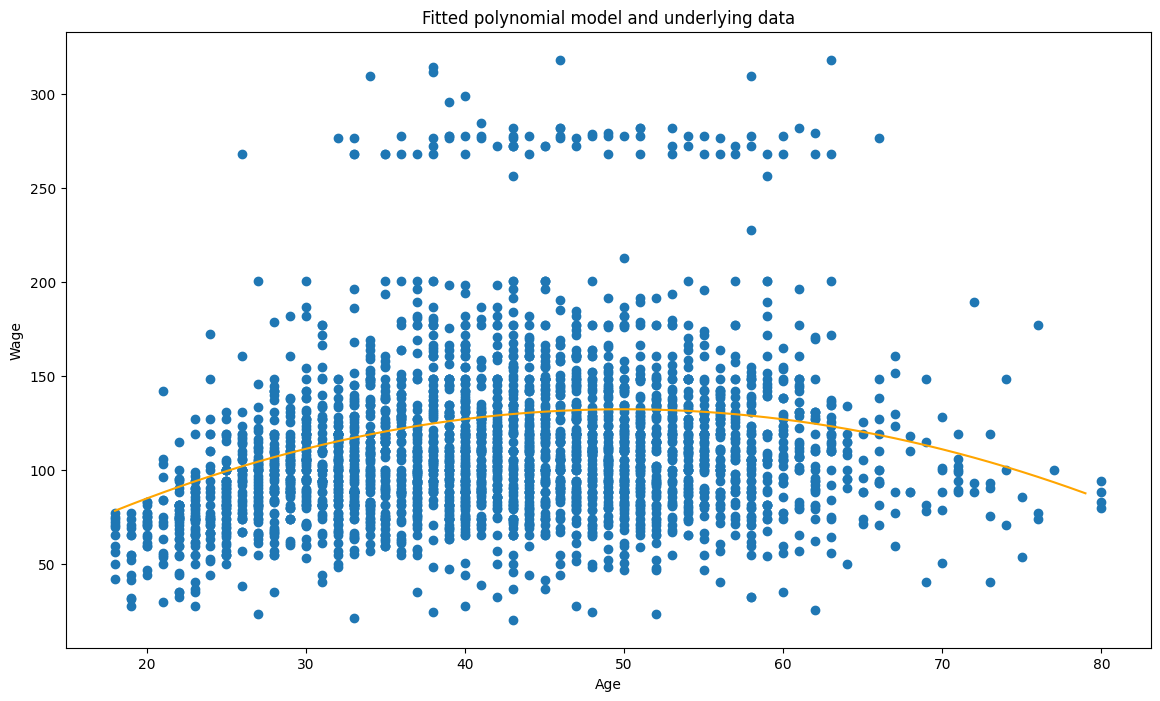

In [80]:
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot()
ax.scatter(age, wage)
ax.plot(age_range, wage_preds, c='orange')

ax.set_title('Fitted polynomial model and underlying data')
ax.set_xlabel('Age')
ax.set_ylabel('Wage')
